In [2]:
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tqdm import tqdm

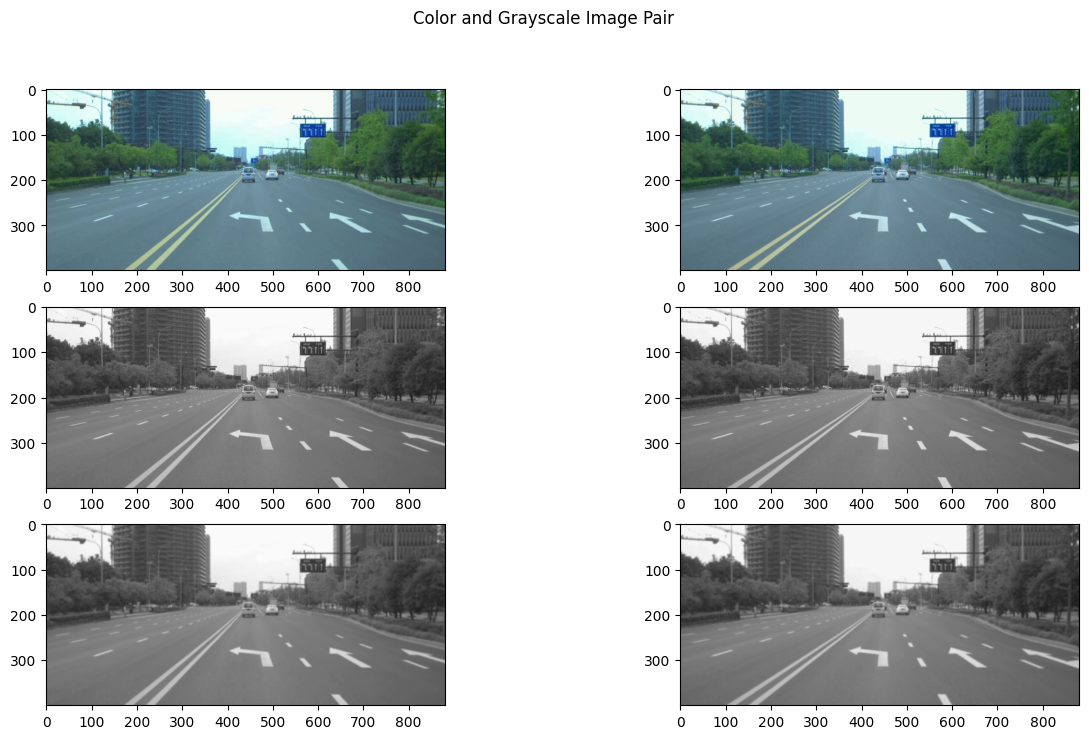

In [12]:
# Load image
rootpath = "./Dataset"
file_prefix = "2018-07-09-16-11-56_2018-07-09-16-"
left_img_suffix = "-left.jpg"
right_img_suffix = "-right.jpg" 
true_img_suffix = "-disparity.png"
image_name = "11-56-702"

img_L = cv2.imread(os.path.join(rootpath, file_prefix + image_name + left_img_suffix), cv2.IMREAD_COLOR)
img_R = cv2.imread(os.path.join(rootpath, file_prefix + image_name + right_img_suffix), cv2.IMREAD_COLOR)
img_tru = cv2.imread(os.path.join(rootpath, file_prefix + image_name + true_img_suffix), cv2.IMREAD_COLOR)

img_L_gray = cv2.cvtColor(img_L, cv2.COLOR_BGR2GRAY)
img_R_gray = cv2.cvtColor(img_R, cv2.COLOR_BGR2GRAY)

img_L_gray_blur = cv2.GaussianBlur(img_L_gray, ksize=[5,5], sigmaX=0, sigmaY=0)
img_R_gray_blur = cv2.GaussianBlur(img_R_gray, ksize=[5,5], sigmaX=0, sigmaY=0)


plt.subplots(figsize=(15, 8))
plt.subplot(3,2,1)
plt.imshow(cv2.cvtColor(img_L, cv2.COLOR_BGR2RGB))
plt.subplot(3,2,2)
plt.imshow(cv2.cvtColor(img_R, cv2.COLOR_BGR2RGB))
plt.subplot(3,2,3)
plt.imshow(cv2.cvtColor(img_L_gray, cv2.COLOR_BGR2RGB))
plt.subplot(3,2,4)
plt.imshow(cv2.cvtColor(img_R_gray, cv2.COLOR_BGR2RGB))
plt.subplot(3,2,5)
plt.imshow(cv2.cvtColor(img_L_gray_blur, cv2.COLOR_BGR2RGB))
plt.subplot(3,2,6)
plt.imshow(cv2.cvtColor(img_R_gray_blur, cv2.COLOR_BGR2RGB))
plt.suptitle("Color and Grayscale Image Pair")
plt.show()

In [13]:
class MatchCost():
    def __init__(self, img_L, img_R):
        self.img_L = img_L
        self.img_R = img_R
    
    def compute(self, disparity_level=5, window_size=3):
        half_window_size = window_size // 2
        H, W = self.img_L.shape
        
        cost_map = np.zeros((H, W, disparity_level), dtype=np.float64)
        
        for h in tqdm(range(half_window_size, H-half_window_size, 1)):
            
            for w in range(half_window_size+ disparity_level, W-half_window_size, 1):
                
                for d in range(disparity_level):
                    if w-half_window_size-d >= 0:
                        cost_map[h,w,d] = -self.normalise_cross_correlate(p_L=(h, w), p_R=(h, w - d), window_size=window_size)
                    else:
                        cost_map[h,w,d] = -self.normalise_cross_correlate(p_L=(h, w), p_R=(h, w), window_size=window_size)
        
        self.cost_map = cost_map
        self.disparity_map = np.argmin(cost_map, axis=2)
        
        return self.disparity_map, self.cost_map
    
    
    def normalise_cross_correlate(self, p_L, p_R, window_size):
        h_L, w_L = p_L
        h_R, w_R = p_R
        
        half_window_size = window_size // 2
        
        matrix_L = self.img_L[h_L - half_window_size : h_L + half_window_size + 1, w_L - half_window_size : w_L + half_window_size + 1]
        matrix_R = self.img_R[h_R - half_window_size : h_R + half_window_size + 1, w_R - half_window_size : w_R + half_window_size + 1]
        
        matrix_L = matrix_L - np.mean(matrix_L)
        matrix_R = matrix_R - np.mean(matrix_R)

        norm_L = np.linalg.norm(matrix_L)
        norm_R = np.linalg.norm(matrix_R)
        return np.sum((matrix_L * matrix_R))/(norm_L * norm_R) if norm_L and norm_R !=0 else 0
        

In [14]:

match_cost = MatchCost(img_L=img_L_gray_blur, img_R=img_R_gray_blur)
disparity_map_NCC, cost_map_NCC = match_cost.compute(disparity_level=10, window_size=5)

100%|██████████| 396/396 [04:16<00:00,  1.55it/s]


In [22]:
class SGM():
    
    def __init__(self, p1, p2, cost_map=None):
        if cost_map is not None:
            self.cost_map = cost_map
        self.p1 = p1
        self.p2 = p2
    
    def compute(self, cost_map=None):
        
        if cost_map is not None:
            self.cost_map = cost_map
        
        H, W, D = self.cost_map.shape
        
        E_init = np.zeros((H, W, D))
        E_init[0, :, :] = self.cost_map[0, :, :]
        E_init[H-1, :, :] = self.cost_map[H-1, :, :]
        E_init[:, 0, :] = self.cost_map[:, 0, :]
        E_init[:, W-1, :] = self.cost_map[:, W-1, :]
        
        # Left to Right scan
        #L2R
        E_a1 = np.copy(E_init)
        E_a1[:, 1:W] = 0
        
        #TL2BR
        E_a5 = np.copy(E_init)
        E_a5[1:H, 1:W] = 0
        
        #BL2TR
        E_a8 = np.copy(E_init)
        E_a8[0:H-1, 1:W] = 0
        
        for w in range(1, W):
            E_a1[:, w, :] = self.cost_map[:, w, :] + self.linear_cost_arggregate(E_pre=E_a1[:, w-1, :])
            
            c_m = self.cost_map[:, w, :]
            c_m[1:H, :] = c_m[1:H, :] + self.linear_cost_arggregate(E_pre=E_a5[:, w-1, :])[0: H-1, :]
            E_a5[:, w, :] = c_m
            
            c_m = self.cost_map[:, w, :]
            c_m[0:H-1, :] = c_m[0:H-1, :] + self.linear_cost_arggregate(E_pre=E_a8[:, w-1, :])[1:H, :]
            E_a8[:, w, :] = c_m
        
        
        # Right to Left scan
        #R2L
        E_a2 = np.copy(E_init)
        E_a2[:, 0:W-1] = 0
        
        #TR2BL
        E_a6 = np.copy(E_init)
        E_a6[1:H, 0:W-1] = 0
        
        #BR2TL
        E_a7 = np.copy(E_init)
        E_a7[0:H-1, 0:W-1] = 0
        
        for w in range(W-2, -1, -1):
            E_a2[:, w, :] = self.cost_map[:, w, :] + self.linear_cost_arggregate(E_pre=E_a2[:, w+1, :])
            
            c_m = self.cost_map[:, w, :]
            c_m[1:H, :] = c_m[1:H, :] + self.linear_cost_arggregate(E_pre=E_a6[:, w+1, :])[0:H-1, :]
            E_a6[:, w, :] = c_m
            
            c_m = self.cost_map[:, w, :]
            c_m[0:H-1, :] =c_m[0:H-1, :] + self.linear_cost_arggregate(E_pre=E_a7[:, w+1, :])[1:H, :]
            E_a7[:, w, :] = c_m
        
        # Top to Bottom scan
        #T2B
        E_a3 = np.copy(E_init)
        E_a3[1:H, :] = 0
        for h in range(1, H):
            E_a3[h, :, :] = self.cost_map[h, :, :] + self.linear_cost_arggregate(E_pre=E_a3[h-1, :, :])
                    
        # Bottom to Top scan
        #B2T
        E_a4 = np.copy(E_init)
        E_a4[0:H-1, :] = 0
        for h in range(H-2, -1, -1):
            E_a4[h, :, :] = self.cost_map[h, :, :] + self.linear_cost_arggregate(E_pre=E_a4[h+1, :, :])
               
        E = np.array(E_a1 + E_a2 + E_a3 + E_a4 + E_a2 + E_a6 + E_a7 + E_a8, dtype=np.int32)
        
        disparity_map = np.argmin(E, axis=2)
        self.disparity_map = disparity_map
        
        return disparity_map
    
    
    def linear_cost_arggregate(self, E_pre):
        R, D = E_pre.shape
        
        d_plus = np.full((R,D), np.inf)
        d_plus[:, 1:D] = E_pre[:, 0:D-1] + self.p1
        
        d_minus = np.full((R,D), np.inf)
        d_minus[:, 0:D-1] = E_pre[:, 1:D] + self.p1
        
        d_min = np.repeat([np.amin(E_pre, axis=1)], D, axis=0).T + self.p2
        
        return np.amin([E_pre, d_plus, d_minus, d_min], axis=0) - (d_min - self.p2)

In [23]:

sgm = SGM(p1=0.009, p2=0.05, cost_map=cost_map_NCC)
disparity_map_SGM = sgm.compute()

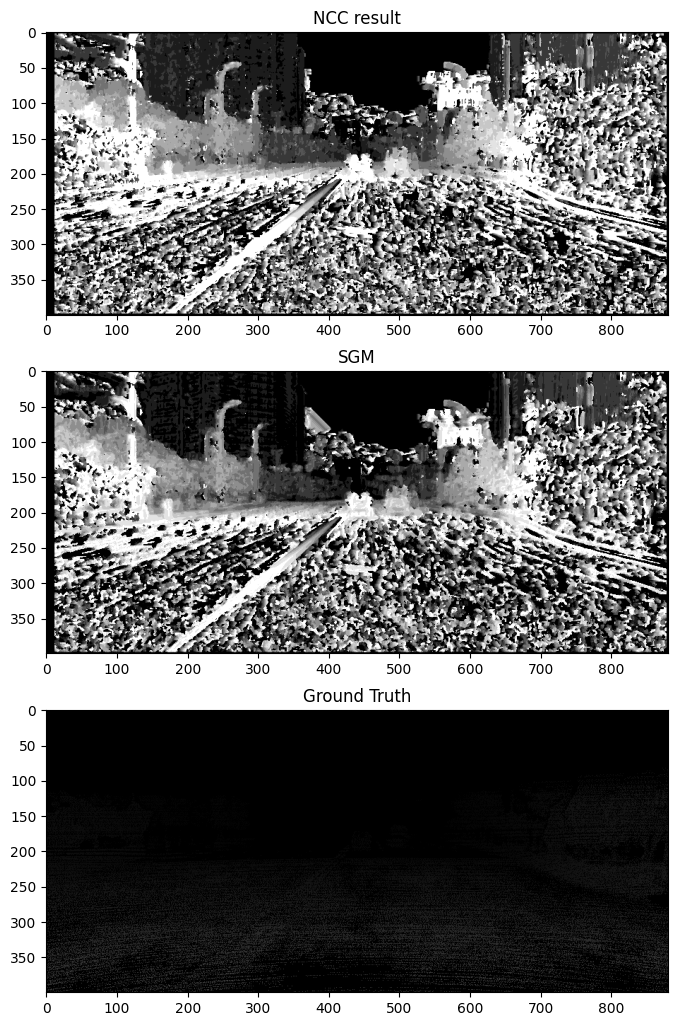

In [24]:
disparity_img_NCC = (disparity_map_NCC/np.max(disparity_map_NCC)) * 255
disparity_img_SGM = (disparity_map_SGM/np.max(disparity_map_SGM) ) *255

plt.subplots(figsize=(20, 8))
plt.subplots_adjust(bottom=0.1, right=0.8, top=1.3)
plt.subplot(3,1,1, title="NCC result")
plt.imshow(disparity_img_NCC, cmap='gray')
plt.subplot(3,1,2, title="SGM")
plt.imshow(disparity_img_SGM, cmap='gray')
plt.subplot(3,1,3, title="Ground Truth")
plt.imshow(img_tru, cmap='gray')

plt.show()

9


In [25]:
# Root mean square error

true_disparity = img_tru[:,:,0]
H, W = true_disparity.shape

error_map = np.full(shape=(H,W), fill_value=np.nan)

count=0
for h in range(H):
    for w in range(W):
        if true_disparity[h,w] != 0:
            error_map[h,w] = disparity_map_SGM[h,w] - true_disparity[h,w]
            count += 1

rmse = np.sum(np.square(error_map)) / count